In [1]:
import pandas as pd
import os
import glob
import io 
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import seaborn as sns
from scipy.stats import zscore
from brainspace.utils.parcellation import reduce_by_labels, map_to_mask
from brainspace.gradient import GradientMaps
from brainspace.datasets import load_parcellation
from brainspace.plotting import plot_hemispheres
from brainspace.utils.parcellation import map_to_labels
from sklearn.metrics.pairwise import cosine_similarity


df = pd.read_table('../participants.tsv')
subjects = df.participant_id.to_list() 
subj = [ s.strip('sub-') for s in subjects ]

labels_gii = nib.load('../cfg/Schaefer2018_1000Parcels_7Networks_order.dlabel.nii').get_fdata()
mask = ~np.isin(labels_gii[0],0)

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


In [2]:
def get_gradients(matrix,region):

    #if region!='ctx':
    matrix= cosine_similarity(matrix.T, matrix.T)

    gm = GradientMaps(n_components=4, random_state=0)
    gm.fit(matrix)

    grad_1 = gm.gradients_.T[0]
    grad_2 = gm.gradients_.T[1]
    grad_3 = gm.gradients_.T[2]
    #grad_4 = gm.gradients_.T[3]

    gradient_df = pd.DataFrame({region+'_grad_1': grad_1, region+'_grad_2': grad_2, region+'_grad_3': grad_3})

    return gradient_df

In [3]:
def get_aligned_gradients(correlation_mean, correlation_matrix):

    #getting the gradinet for the mean
    ngradients = 4
    gm = GradientMaps(n_components=ngradients, kernel='normalized_angle', approach='dm', random_state=0)
    gm.fit(correlation_mean)

    #getting the gradient for individual subject and aligning with the average
    gp = GradientMaps(n_components=ngradients, kernel='normalized_angle',approach='dm', random_state=0,alignment='procrustes')
        
    # With procrustes alignment
    nsubjects = len(subj)
    for s in range(0,len(subj)):
        gp.fit(correlation_data[:,:,s], reference=gm.gradients_) # i.e., 3D matrix, with third dimension = subjects


    return gm,gp.aligned_.T

In [4]:

import itertools
def reject_outliers_2(matrix, m=2.):

    mean_matrix = np.zeros((np.shape(matrix)[0],np.shape(matrix)[1]))
    for i, j in itertools.product(range(np.shape(matrix)[0]),range(np.shape(matrix)[1])):

        data = matrix[i,j,:]
        d = np.abs(data - np.median(data))
        mdev = np.median(d)
        s = d / (mdev if mdev else 1.)
        mean_matrix[i,j] = np.mean(data[s < m])
    return mean_matrix






In [21]:



def get_mean_matrix(session,region):
    #subj = ['3119','3120']
    matrix_dir = '/home/dimuthu1/scratch/PPMI_project2/derivatives/analysis/corr_matrix/'+session

    matrix = np.load(matrix_dir+"/sub-"+subj[0]+"_"+session+"_corr-matrix.npy")

    plt.figure(figsize=(20,20))
    plt.imshow(matrix)
    plt.colorbar()
    plt.savefig('/home/dimuthu1/scratch/PPMI_project2/derivatives/analysis/plots/correlation.png')

    plt.show()
    

    if region=='ctx':
        sliced_matrix = matrix[:1000,:1000]
    if region=='sbctx':
        sliced_matrix = matrix[:1000,1000:]

    cube_matrix = np.zeros((np.shape(sliced_matrix)[0],np.shape(sliced_matrix)[1],len(subj)))

    
    for i,subjects in enumerate(subj):
        
        matrix = np.load(matrix_dir+"/sub-"+subj[0]+"_"+session+"_corr-matrix.npy")

        if region=='ctx':
            sliced_matrix = matrix[:1000,:1000]
        if region=='sbctx':
            sliced_matrix = matrix[:1000,1000:]

        cube_matrix[:,:,i]=sliced_matrix

    mean_data = np.mean(cube_matrix, axis=2)
    #mean_data = reject_outliers_2(cube_matrix, m=2.)

    return mean_data, cube_matrix






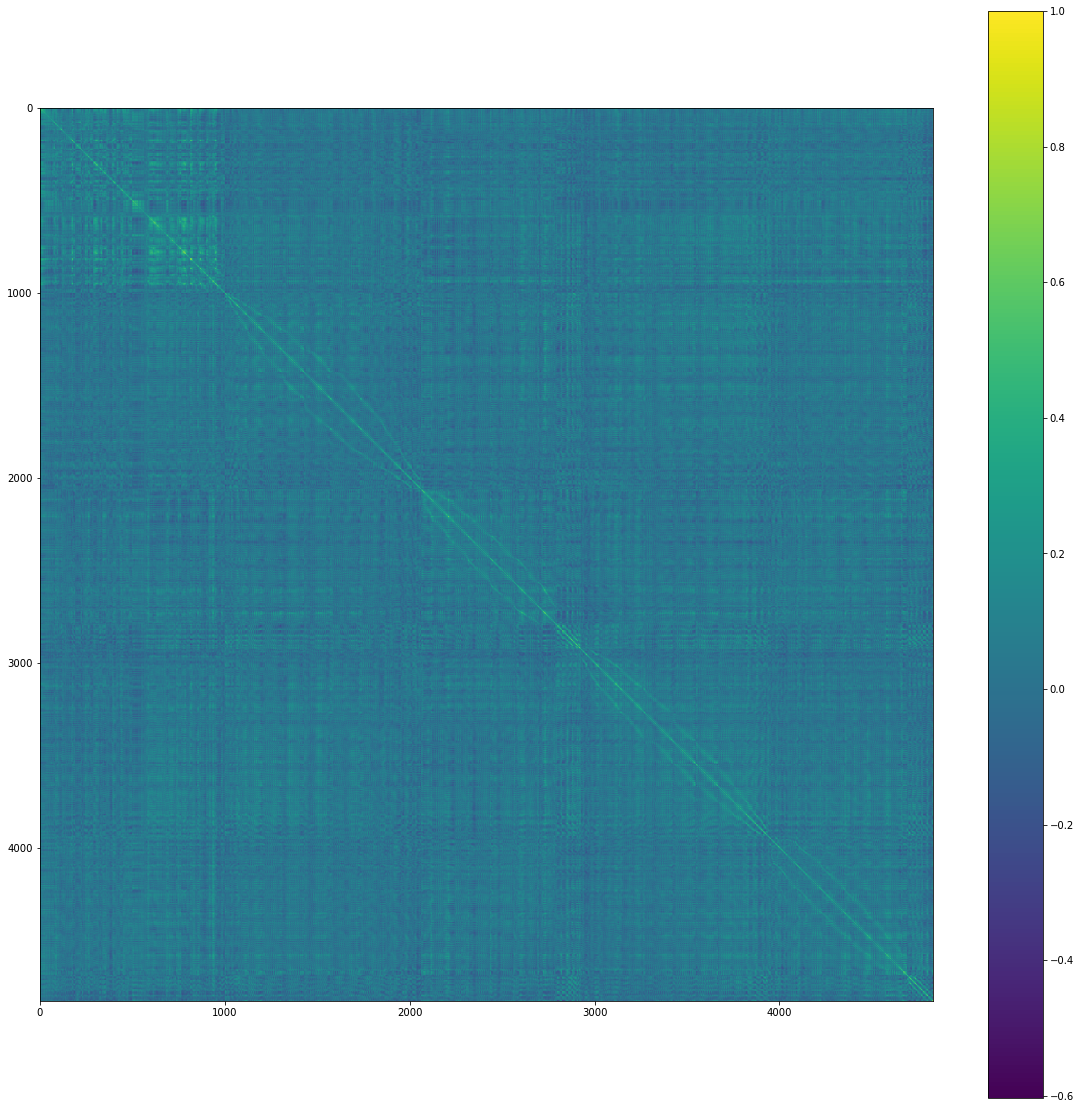

"mean_ctx_12, cube_matrix_ctx_12 = get_mean_matrix('month12','ctx')\nmean_ctx_24, cube_matrix_ctx_24 = get_mean_matrix('month24','ctx')\n\nprint(np.shape(mean_sbctx_12))\nprint(np.shape(cube_matrix_sbctx_12))\n\nprint(np.shape(mean_ctx_12))\nprint(np.shape(cube_matrix_ctx_12))"

In [22]:
mean_sbctx_12, cube_matrix_sbctx_12 = get_mean_matrix('month12','sbctx')
#mean_sbctx_24, cube_matrix_sbctx_24 = get_mean_matrix('month24','sbctx')

"""mean_ctx_12, cube_matrix_ctx_12 = get_mean_matrix('month12','ctx')
mean_ctx_24, cube_matrix_ctx_24 = get_mean_matrix('month24','ctx')

print(np.shape(mean_sbctx_12))
print(np.shape(cube_matrix_sbctx_12))

print(np.shape(mean_ctx_12))
print(np.shape(cube_matrix_ctx_12))"""

#df_sbctx_12 = get_gradients(mean_sbctx_12,'sbctx')
#df_sbctx_24 = get_gradients(mean_sbctx_24,'sbctx')

#df_sbctx_12['month'] = 'm12'
#df_sbctx_24['month'] = 'm24'


#df_sbctx_all = df_sbctx_24.append(df_sbctx_12)
#out_path='/home/dimuthu1/scratch/PPMI_project2/derivatives/analysis/plots/group'
#sns_plot = sns.pairplot(df_sbctx_all,plot_kws={"s": 5}, hue="month")
#sns_plot.savefig(out_path+"/group_stat_sbctx.png")

#df_sbctx_all.to_csv(out_path+"/sbctx_gradients.csv", index=False)

In [38]:
grad, aligned_grad = get_aligned_gradients(mean_ctx_12, cube_matrix_ctx_12)

NameError: name 'data' is not defined

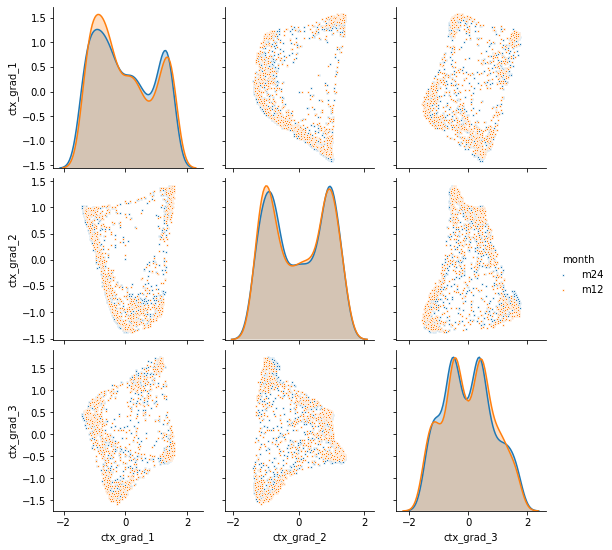

In [47]:
mean_ctx_12 = get_mean_matrix('month12','ctx')
mean_ctx_24 = get_mean_matrix('month24','ctx')

df_ctx_12 = get_gradients(mean_ctx_12,'ctx')
df_ctx_24 = get_gradients(mean_ctx_24,'ctx')


df_ctx_12['month'] = 'm12'
df_ctx_24['month'] = 'm24'


df_ctx_all = df_ctx_24.append(df_ctx_12)

out_path='/home/dimuthu1/scratch/PPMI_project2/derivatives/analysis/plots/group'
sns_plot = sns.pairplot(df_ctx_all,plot_kws={"s": 5}, hue="month")
sns_plot.savefig(out_path+"/group_stat_ctx.png")

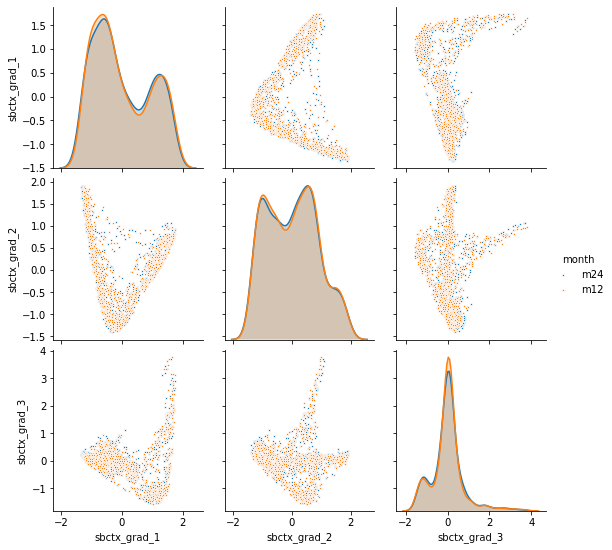

In [49]:
mean_sbctx_12 = get_mean_matrix('month12','sbctx')
mean_sbctx_24 = get_mean_matrix('month24','sbctx')

df_sbctx_12 = get_gradients(mean_sbctx_12.T,'sbctx')
df_sbctx_24 = get_gradients(mean_sbctx_24.T,'sbctx')

df_sbctx_12['month'] = 'm12'
df_sbctx_24['month'] = 'm24'


df_sbctx_all = df_sbctx_24.append(df_sbctx_12)
out_path='/home/dimuthu1/scratch/PPMI_project2/derivatives/analysis/plots/group'
sns_plot = sns.pairplot(df_sbctx_all,plot_kws={"s": 5}, hue="month")
sns_plot.savefig(out_path+"/group_stat_sbctx.png")

#df_sbctx_all.to_csv(out_path+"/sbctx_gradients.csv", index=False)